# Knowledge Destillation - Vanilla

This notebook is heavily based on Keras's [knowledge distillation example](https://keras.io/examples/vision/knowledge_distillation/) and on Hilton et al., 2015:

```
@article{hinton2015distilling,
  title={Distilling the knowledge in a neural network},
  author={Hinton, Geoffrey and Vinyals, Oriol and Dean, Jeff},
  journal={arXiv preprint arXiv:1503.02531},
  year={2015}
}
```

In [ ]:
#@title

! pip -qq install -U tensorflow_addons

import tensorflow as tf

for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') to memory-growth mode.


In [ ]:
import tensorflow as tf

DATA_SOURCE = '/content/drive/Shareddrives/datasets/voc-2012.tar.gz'
LOGS = '/content/drive/Shareddrives/zh/logs/pascal-2012'

class Config:
  class data:
    size = (512, 512)
    shape = (*size, 3)
    batch_size = 16
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = True
    classes = 20

    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    deprocess = lambda x: tf.cast(tf.clip_by_value((x+1)*127.5, 0, 255), tf.uint8)
    source = DATA_SOURCE

  class aug:
    brightness_delta =  .2
    saturation_lower =  .2
    saturation_upper = 1.0
    contrast_lower   =  .5
    contrast_upper   = 1.5
    hue_delta        =  .0
    
  class teacher:
    backbone = tf.keras.applications.ResNet101V2
    weights = f'{LOGS}/resnet101-ce-fine-tune/weights.h5'
    fine_tune_layers = .6
    freeze_batch_norm = False
    dropout_rate = 0.5
  
  class training:
    epochs = 120
    lr_first_decay_steps = 50
    dropout_rate = 0.5
    
    early_reduce_lr_patience = 8
    early_stopping_patience = 30
  
    baseline_logs = f'{LOGS}/kd/resnet50-baseline'
    vanilla_student_logs = f'{LOGS}/kd/resnet50-vanilla-student'

  class experiment:
    seed = 11963
    override = True

In [ ]:
input_tensor = tf.keras.Input(Config.data.shape, name='images')

In [ ]:
student_backbone = tf.keras.applications.ResNet50V2(
  input_tensor=input_tensor,
  include_top=False,
  weights=None,
)

In [ ]:
teacher_backbone = Config.teacher.backbone(
  input_tensor=input_tensor,
  include_top=False
)

teacher_backbone.trainable = False

## Setup

In [ ]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

In [ ]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')
C = np.asarray(sns.color_palette("Set1", 21))
CMAP = sns.color_palette("Set1", 21, as_cmap=True)

sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x


def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    figsize=(16, 7.2),
    cmap=None
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [ ]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

def build_classifier(backbone, dropout_rate=None, name=None):
  y = backbone(input_tensor)
  y = GlobalAveragePooling2D(name='avg_pool')(y)
  y = Dropout(rate=dropout_rate, name='top_dropout')(y)
  y = Dense(Config.data.classes, name='predictions')(y)

  return tf.keras.Model(
    inputs=input_tensor,
    outputs=y,
    name=name)


def unfreeze_top_layers(
    model: tf.keras.Model,
    layers: float,
    freeze_bn: bool
):
  if not layers:
    model.trainable = False
    return

  model.trainable = True

  frozen_layer_ix = int((1-layers) * len(model.layers))
  for ix, l in enumerate(model.layers):
    l.trainable = (ix > frozen_layer_ix and
                   (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not freeze_bn))
  
  print(f'Unfreezing {layers:.0%} layers. Bottom-most is the {frozen_layer_ix}-nth layer ({model.layers[frozen_layer_ix].name}).')


def train_fn(
    nn: tf.keras.Model,
    train: tf.data.Dataset,
    valid: tf.data.Dataset,
    epochs: int,
    logs: str,
    weights: str,
    initial_epoch:int = 0,
    override: bool = False,
):
  try:
    if os.path.exists(logs) and initial_epoch == 0:
      if not override:
        raise ValueError(f'A training was found in {logs}. Either move it or set experiment.override to True.')

      print(f'Overriding previous training at {logs}.')
      shutil.rmtree(logs)
    
    os.makedirs(os.path.dirname(weights), exist_ok=True)

    nn.fit(
      train,
      validation_data=valid,
      epochs=epochs,
      initial_epoch=initial_epoch,
      callbacks=[
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(weights, save_best_only=True, save_weights_only=True, verbose=1),
        callbacks.TensorBoard(logs, profile_batch=False),
        callbacks.EarlyStopping(patience=Config.training.early_stopping_patience, verbose=1),
        ReduceLRBacktrack(weights, factor=0.5, patience=Config.training.early_reduce_lr_patience, min_lr=0.001, verbose=1),
      ]);

  except KeyboardInterrupt: print('\ninterrupted')
  else: print('\ndone')

In [ ]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging

class ReduceLRBacktrack(ReduceLROnPlateau):
    """
    Reduce Learning Rate on Plateau and restore weights.
    
    Ref: https://stackoverflow.com/a/55228619/2429640
    """
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            tf_logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                               'which is not available. Available metrics are: %s',
                               self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):
            if not self.in_cooldown():
                if self.wait+1 >= self.patience:
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs)

In [ ]:
class FromLogitsMixin:
  def __init__(self, from_logits=False, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.from_logits = from_logits

  def update_state(self, y_true, y_pred, sample_weight=None):
    if self.from_logits:
      y_pred = tf.nn.sigmoid(y_pred)
    return super().update_state(y_true, y_pred, sample_weight)


class BinaryAccuracy(FromLogitsMixin, tf.metrics.BinaryAccuracy):
  ...

class TruePositives(FromLogitsMixin, tf.metrics.TruePositives):
  ...

class FalsePositives(FromLogitsMixin, tf.metrics.FalsePositives):
  ...

class TrueNegatives(FromLogitsMixin, tf.metrics.TrueNegatives):
  ...

class FalseNegatives(FromLogitsMixin, tf.metrics.FalseNegatives):
  ...

class Precision(FromLogitsMixin, tf.metrics.Precision):
  ...

class Recall(FromLogitsMixin, tf.metrics.Recall):
  ...

class F1Score(FromLogitsMixin, tfa.metrics.F1Score):
  ...

## Dataset

### Augmentation Policy

In [ ]:
def default_policy_fn(image):
  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [ ]:
(train_dataset, val_dataset, test_dataset), info = tfds.load(
  'voc/2012',
  split=('train', 'validation', 'test'),
  with_info=True,
  shuffle_files=False,
)

In [ ]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [ ]:
from functools import partial


@tf.function
def load_fn(d, augment=False, named=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = Config.data.preprocess(image)

  if named:
    return d['image/filename'], image, labels_to_one_hot(labels)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False, named=False, drop_remainder=True):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment, named=named), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=drop_remainder)
            .prefetch(Config.data.prefetch_buffer_size))

In [ ]:
train = prepare(train_dataset, Config.data.batch_size, shuffle=True, augment=True)
valid = prepare(val_dataset, Config.data.batch_size)
test = prepare(test_dataset, Config.data.batch_size, named=True, drop_remainder=False)

### Examples in The Dataset

In [ ]:
#@title

def talk_about(dataset, batches, tag):
  print(tag)
  print(f'  {batches}')
  print(f'  samples: {len(dataset)}')
  print(f'  steps  : {len(batches)}')
  print()


talk_about(train_dataset, train, 'Training')
talk_about(val_dataset, valid, 'Validation')
talk_about(test_dataset, test, 'Testing')

Training
  <PrefetchDataset shapes: ((16, 512, 512, 3), (16, 20)), types: (tf.float32, tf.float32)>
  samples: 5717
  steps  : 357

Validation
  <PrefetchDataset shapes: ((16, 512, 512, 3), (16, 20)), types: (tf.float32, tf.float32)>
  samples: 5823
  steps  : 363

Testing
  <PrefetchDataset shapes: ((None,), (None, 512, 512, 3), (None, 20)), types: (tf.string, tf.float32, tf.float32)>
  samples: 10991
  steps  : 687



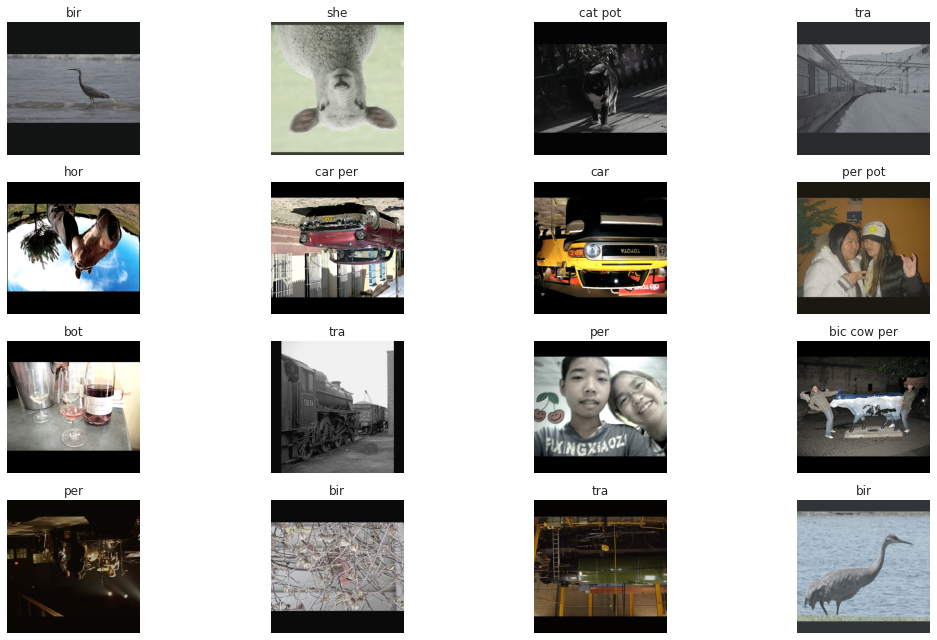

In [ ]:
#@title

for images, labels in train.take(1):
  gt = [' '.join((e[:3] for e in CLASSES[l].astype(str)))
        for l in labels.numpy().astype(bool)]

  visualize(
    Config.data.deprocess(images[:32]),
    gt,
    rows=4,
    figsize=(16, 9)
  )

  plt.savefig('train-examples.jpg')

## Baseline Network

In [ ]:
student = build_classifier(
  student_backbone,
  dropout_rate=Config.training.dropout_rate,
  name='resnet50_student_voc12')

student.compile(
  optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=[
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro'),
    Precision(from_logits=True),
    Recall(from_logits=True),
    tf.keras.metrics.AUC(multi_label=True, from_logits=True),
  ])

In [ ]:
student.summary()

Model: "resnet50_student_voc12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 512, 512, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 16, 16, 2048)      23564800  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
top_dropout (Dropout)        (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 20)                40980     
Total params: 23,605,780
Trainable params: 23,560,340
Non-trainable params: 45,440
_________________________________________________________________


### Training

In [ ]:
train_fn(
  student,
  train,
  valid,
  epochs=Config.training.epochs,
  logs=Config.training.baseline_logs,
  weights=f'{Config.training.baseline_logs}/weights.h5',
)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/120
178/178 [==============================] - 407s 2s/step - loss: 0.2610 - f1_score: 0.0452 - precision: 0.2922 - recall: 0.0439 - auc: 0.5535 - val_loss: 0.2453 - val_f1_score: 0.0379 - val_precision: 0.8333 - val_recall: 5.6773e-04 - val_auc: 0.6132

Epoch 00001: val_loss improved from inf to 0.24533, saving model to /content/drive/Shareddrives/zh/logs/pascal-2012/kd/resnet50-baseline/weights.h5
Epoch 2/120
178/178 [==============================] - 400s 2s/step - loss: 0.2425 - f1_score: 0.0613 - precision: 0.4371 - recall: 0.0520 - auc: 0.6348 - val_loss: 0.2384 - val_f1_score: 0.0588 - val_precision: 0.5571 - val_recall: 0.0044 - val_auc: 0.6760

Epoch 00002: val_loss improved from 0.24533 to 0.23840, saving model to /content/drive/Shareddrives/zh/logs/pascal-2012/kd/resnet50-baseline/weights.h5
Epoch 3/120
178/178 [==============================] - 399s 2s/step - loss: 0.2367 - f1_score: 0.0760 - precision: 0.4688 - recall: 0.0654 - auc: 0.6702 - val_loss: 0.2429 - val_

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fdad5eebc20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 47/120
178/178 [==============================] - 398s 2s/step - loss: 0.1308 - f1_score: 0.4584 - precision: 0.7773 - recall: 0.4864 - auc: 0.9354 - val_loss: 0.1818 - val_f1_score: 0.3339 - val_precision: 0.6461 - val_recall: 0.3354 - val_auc: 0.8727

Epoch 00047: val_loss did not improve from 0.18026
Epoch 48/120
178/178 [==============================] - 400s 2s/step - loss: 0.1298 - f1_score: 0.4576 - precision: 0.7887 - recall: 0.4997 - auc: 0.9355 - val_loss: 0.2014 - val_f1_score: 0.3339 - val_precision: 0.5810 - val_recall: 0.3469 - val_auc: 0.8605

Epoch 00048: val_loss did not improve from 0.18026
Epoch 49/120
178/178 [==============================] - 398s 2s/step - loss: 0.1271 - f1_score: 0.4703 - precision: 0.7938 - recall: 0.5063 - auc: 0.9393 - val_loss: 0.2043 - val_f1_score: 0.2738 - val_precision: 0.5634 - val_recall: 0.4256 - val_auc: 0.8686

Epoch 00049: val_loss did not improve from 0.18026
Epoch 50/120
178/178 [==============================] - 402s 2s/ste

## Teacher-Student Vanilla Knowledge Distillation

In [ ]:
teacher = build_classifier(
  teacher_backbone,
  dropout_rate=Config.teacher.dropout_rate,
  name='resnet101_teacher_voc12')

unfreeze_top_layers(
  teacher_backbone,
  Config.teacher.fine_tune_layers,
  Config.teacher.freeze_batch_norm
)

teacher.load_weights(Config.teacher.weights)

teacher.trainable = False

Unfreezing 60% layers. Bottom-most is the 150-nth layer (conv4_block6_2_relu).


In [ ]:
student = build_classifier(
  student_backbone,
  dropout_rate=Config.training.dropout_rate,
  name='resnet50_student_voc12')

In [ ]:
class Distiller(tf.keras.Model):
  def __init__(
      self,
      student,
      teacher,
      alpha=0.1,
      temperature=3,
      distillation_loss=None,
      **kwargs
  ):
    super().__init__(**kwargs)
    self.student = student
    self.teacher = teacher

    self.alpha = alpha
    self.temperature = temperature

    self.distillation_loss = distillation_loss or tf.keras.losses.KLDivergence()
  
  def get_config(self):
    config = super().get_config()
    config.update(alpha=self.alpha, temperature=self.temperature)

    return config
  
  def call(self, inputs):
    return self.student(inputs)

  def train_step(self, data):
    if len(data) == 3:
      x, y, sample_weight = data
    else:
      sample_weight = None
      x, y = data

    tp = self.teacher(x, training=False)

    with tf.GradientTape() as tape:
        sp = self.student(x, training=True)

        student_loss = self.compiled_loss(
          y,
          sp,
          sample_weight=sample_weight,
          regularization_losses=self.losses
        )

        distillation_loss = self.distillation_loss(
            tf.nn.softmax(tp / self.temperature, axis=1),
            tf.nn.softmax(sp / self.temperature, axis=1),
        )

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

    trainable_variables = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)

    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    self.compiled_metrics.update_state(y, sp)

    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})

    return results

  def test_step(self, data):
    x, y = data
    sp = self.student(x, training=False)
    student_loss = self.compiled_loss(y, sp, regularization_losses=self.losses)
    self.compiled_metrics.update_state(y, sp)

    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})

    return results

In [ ]:
#@title

# this does not work:
# class Distiller(tf.keras.Model):
#   def __init__(
#       self,
#       student,
#       teacher,
#       alpha=0.1,
#       temperature=3,
#       distillation_loss=None,
#       **kwargs
#   ):
#     super().__init__(**kwargs)
#     self.student = student
#     self.teacher = teacher

#     self.alpha = alpha
#     self.temperature = temperature

#     self.distillation_loss = distillation_loss or tf.keras.losses.KLDivergence()

#   def call(self, inputs):
#     lt = self.teacher(inputs)
#     ls = self.student(inputs)

#     self.add_loss(lambda: (1 - self.alpha) * self.distillation_loss(
#       tf.nn.sigmoid(lt / self.temperature),
#       tf.nn.sigmoid(ls / self.temperature)
#     ))

#     return ls

#   def get_config(self):
#     return {'alpha': self.alpha, 'temperature': self.temperature, 'distillation_loss': self.distillation_loss}

In [ ]:
lecture = Distiller(
  student,
  teacher,
  alpha=0.1,
  temperature=10,
  name='distiller_voc12'
)

In [ ]:
lecture.build((None, *Config.data.shape))

lecture.compile(
  optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True),
  loss=tf.losses.BinaryCrossentropy(from_logits=True),
  metrics=[
    F1Score(num_classes=len(CLASSES), from_logits=True, average='macro', name='f1_score'),
    Precision(from_logits=True, name='precision'),
    Recall(from_logits=True, name='recall'),
    tf.keras.metrics.AUC(multi_label=True, from_logits=True, name='auc'),
  ])

### Training

In [ ]:
train_fn(
  lecture,
  train,
  valid,
  epochs=Config.training.epochs,
  logs=Config.training.vanilla_student_logs,
  weights=f'{Config.training.vanilla_student_logs}/weights.h5',
  override=True
)

Overriding previous training at /content/drive/Shareddrives/zh/logs/pascal-2012/kd/resnet50-vanilla-student.
Epoch 1/120
178/178 [==============================] - 511s 3s/step - loss: 0.3114 - f1_score: 0.0398 - precision: 0.3115 - recall: 0.2348 - auc: 0.5531 - student_loss: 0.3113 - distillation_loss: 0.1537 - val_loss: 0.2616 - val_f1_score: 0.0440 - val_precision: 0.3847 - val_recall: 0.2542 - val_auc: 0.6155 - val_student_loss: 0.2458

Epoch 00001: val_loss improved from inf to 0.26156, saving model to /content/drive/Shareddrives/zh/logs/pascal-2012/kd/resnet50-vanilla-student/weights.h5
Epoch 2/120
178/178 [==============================] - 518s 3s/step - loss: 0.2888 - f1_score: 0.0542 - precision: 0.3851 - recall: 0.2328 - auc: 0.6305 - student_loss: 0.2886 - distillation_loss: 0.1465 - val_loss: 0.2618 - val_f1_score: 0.0601 - val_precision: 0.4368 - val_recall: 0.2126 - val_auc: 0.6929 - val_student_loss: 0.2279

Epoch 00002: val_loss did not improve from 0.26156
Epoch 3/120

## Evaluation

In [ ]:
classification_threshold = 0.5

In [ ]:
#@title

from sklearn import metrics as skmetrics

def labels_and_probs(nn, dataset):
  labels_ = []
  probs_ = []

  for ix, (images, labels) in enumerate(dataset):
    y = nn(images, training=False)
    y = tf.nn.sigmoid(y)

    labels_.append(labels)
    probs_.append(y)

    print('.', end='' if (ix+1) % 120 else '\n')
  
  return (tf.concat(labels_, axis=0),
          tf.concat(probs_, axis=0))

def metrics_per_label(gt, probs, threshold=0.5):
  p_pred = tf.cast(probs > threshold, probs.dtype).numpy()

  tru_ = tf.reduce_sum(gt, axis=0)
  neg_ = tf.reduce_sum(1- gt, axis=0)

  tpr = tf.reduce_sum(p_pred*gt, axis=0) / tru_
  fpr = tf.reduce_sum(p_pred*(1-gt), axis=0) / neg_
  tnr = tf.reduce_sum((1-p_pred)*(1-gt), axis=0) / neg_
  fnr = tf.reduce_sum((1-p_pred)*gt, axis=0) / tru_
  
  f2_score = skmetrics.fbeta_score(gt, p_pred, beta=2, average=None)
  precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(
    gt, p_pred, average=None)

  mcm = skmetrics.multilabel_confusion_matrix(gt, p_pred)

  return pd.DataFrame({
    'true positive r': tpr,
    'true negative r': tnr,
    'false positive r': fpr,
    'false negative r': fnr,
    'precision': precision,
    'recall': recall,
    'auc_score': skmetrics.roc_auc_score(gt, probs, average=None),
    'f1_score': f1_score,
    'f2_score': f2_score,
    'support': support,
    'label': CLASSES
  }), mcm


### Teacher Model

In [ ]:
l, p = labels_and_probs(teacher, valid)

test_report, test_mcm = metrics_per_label(l, p, threshold=classification_threshold)

t = pd.DataFrame(test_report.mean(axis=0)).T
t['label'] = 'macro avg.'

test_report.append(t)

........................................................................................................................
.............................................................

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.933333,0.998348,0.001652,0.066667,0.972810,0.933333,0.997921,0.952663,0.940970,345.00,aeroplane
1,0.819444,0.996366,0.003634,0.180556,0.921875,0.819444,0.982655,0.867647,0.838068,288.00,bicycle
2,0.916890,0.997970,0.002030,0.083110,0.968839,0.916890,0.988178,0.942149,0.926829,373.00,bird
3,0.800000,0.996030,0.003970,0.200000,0.900901,0.800000,0.988319,0.847458,0.818331,250.00,boat
4,0.600543,0.986726,0.013274,0.399457,0.754266,0.600543,0.949948,0.668684,0.626062,368.00,bottle
5,0.870813,0.997851,0.002149,0.129187,0.938144,0.870813,0.983127,0.903226,0.883495,209.00,bus
6,0.694215,0.991324,0.008676,0.305785,0.903226,0.694215,0.959800,0.785047,0.727903,605.00,car
7,0.940959,0.998286,0.001714,0.059041,0.982659,0.940959,0.996494,0.961357,0.949014,542.00,cat
8,0.645312,0.979231,0.020769,0.354688,0.794231,0.645312,0.950089,0.712069,0.670455,640.00,chair
9,0.789474,0.996454,0.003546,0.210526,0.857143,0.789474,0.991875,0.821918,0.802139,152.00,cow


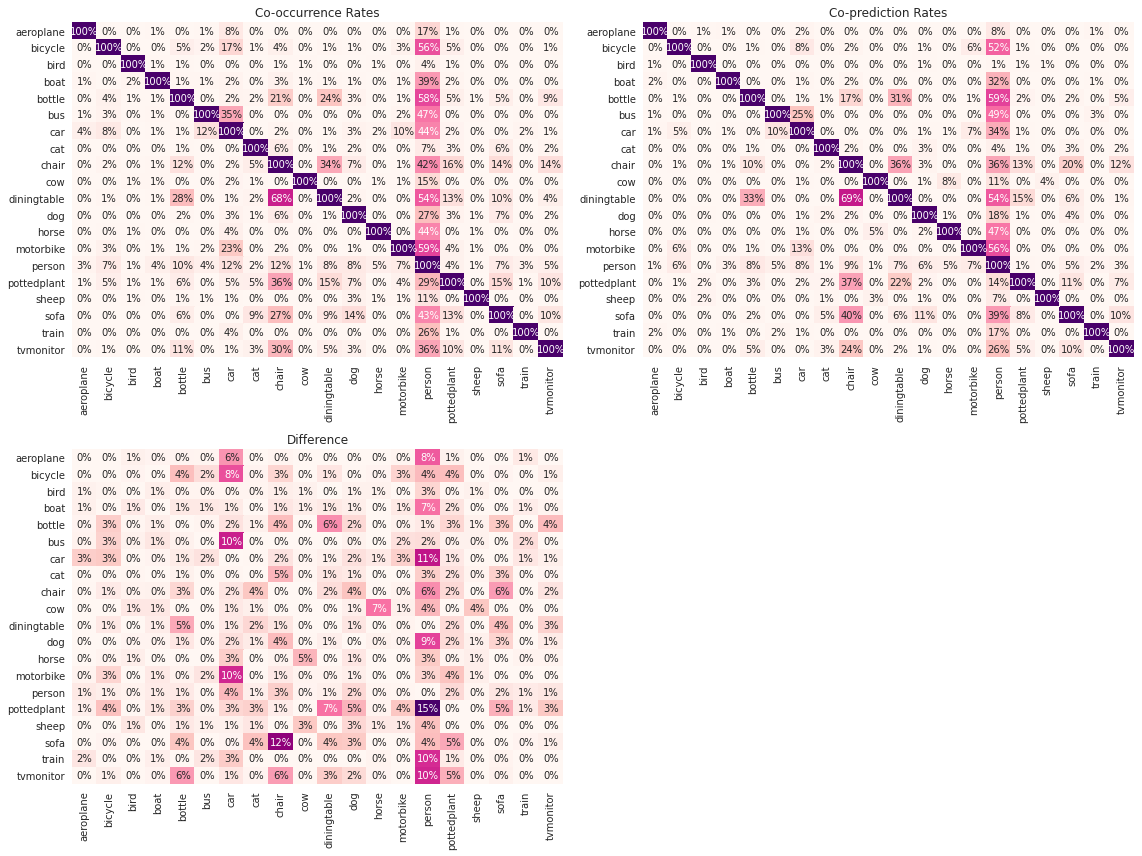

In [ ]:
#@title

def plot_occurrence_and_prediction_matrices(l, p):
  co_occurrence = tf.transpose(l) @ l
  co_occurrence_rate = tf.math.divide_no_nan(
    co_occurrence,
    tf.reshape(np.diag(co_occurrence), (-1, 1)))

  d = tf.cast(p > classification_threshold, p.dtype)
  co_prediction = tf.transpose(d) @ d
  co_prediction_rate = tf.math.divide_no_nan(
    co_prediction,
    tf.reshape(np.diag(co_prediction), (-1, 1)))

  plt.figure(figsize=(16, 12))
  plt.subplot(221)
  plt.title('Co-occurrence Rates')
  sns.heatmap(
    co_occurrence_rate.numpy(),
    annot=True,
    fmt='.0%',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="RdPu",
    cbar=False
  )
  plt.subplot(222)
  plt.title('Co-prediction Rates')
  sns.heatmap(
    co_prediction_rate.numpy(),
    annot=True,
    fmt='.0%',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="RdPu",
    cbar=False
  )
  plt.subplot(223)
  plt.title('Difference')
  sns.heatmap(
    tf.abs(co_occurrence_rate - co_prediction_rate).numpy(),
    annot=True,
    fmt='.0%',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cmap="RdPu",
    cbar=False
  )
  plt.tight_layout();

plot_occurrence_and_prediction_matrices(l, p)

### Baseline Model

In [ ]:
student.load_weights(f'{Config.training.baseline_logs}/weights.h5')

In [ ]:
l, p = labels_and_probs(student, valid)

test_report, test_mcm = metrics_per_label(l, p)

........................................................................................................................
.............................................................

In [ ]:
t = pd.DataFrame(test_report.mean(axis=0)).T
t['label'] = 'macro avg.'

test_report.append(t)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.617391,0.988434,0.011566,0.382609,0.771739,0.617391,0.960453,0.685990,0.643116,345.00,aeroplane
1,0.187500,0.994368,0.005632,0.812500,0.635294,0.187500,0.883290,0.289544,0.218270,288.00,bicycle
2,0.396783,0.984868,0.015132,0.603217,0.643478,0.396783,0.908508,0.490879,0.429733,373.00,bird
3,0.372000,0.990437,0.009563,0.628000,0.636986,0.372000,0.908333,0.469697,0.405759,250.00,boat
4,0.027174,0.998341,0.001659,0.972826,0.526316,0.027174,0.810266,0.051680,0.033535,368.00,bottle
5,0.555024,0.991582,0.008418,0.444976,0.711656,0.555024,0.957351,0.623656,0.580581,209.00,bus
6,0.373554,0.975323,0.024677,0.626446,0.638418,0.373554,0.881752,0.471324,0.407354,605.00,car
7,0.402214,0.971048,0.028952,0.597786,0.589189,0.402214,0.900321,0.478070,0.429472,542.00,cat
8,0.350000,0.969526,0.030474,0.650000,0.587927,0.350000,0.854593,0.438786,0.380823,640.00,chair
9,0.052632,0.998050,0.001950,0.947368,0.421053,0.052632,0.899139,0.093567,0.063796,152.00,cow


### Distilled Student Model

In [ ]:
lecture.load_weights(f'{Config.training.vanilla_student_logs}/weights.h5')

In [ ]:
l, p = labels_and_probs(lecture, valid)

test_report, test_mcm = metrics_per_label(l, p)

........................................................................................................................
.............................................................

In [ ]:
t = pd.DataFrame(test_report.mean(axis=0)).T
t['label'] = 'macro avg.'

test_report.append(t)

,true positive r,true negative r,false positive r,false negative r,precision,recall,auc_score,f1_score,f2_score,support,label
0,0.715942,0.980540,0.019460,0.284058,0.699717,0.715942,0.961891,0.707736,0.712637,345.00,aeroplane
1,0.246528,0.987827,0.012173,0.753472,0.514493,0.246528,0.880974,0.333333,0.275194,288.00,bicycle
2,0.546917,0.958848,0.041152,0.453083,0.477752,0.546917,0.892657,0.510000,0.531527,373.00,bird
3,0.384000,0.989534,0.010466,0.616000,0.623377,0.384000,0.902129,0.475248,0.415945,250.00,boat
4,0.043478,0.992810,0.007190,0.956522,0.290909,0.043478,0.812154,0.075650,0.052390,368.00,bottle
5,0.722488,0.980476,0.019524,0.277512,0.580769,0.722488,0.953404,0.643923,0.688869,209.00,bus
6,0.439669,0.962984,0.037016,0.560331,0.580786,0.439669,0.882012,0.500470,0.462126,605.00,car
7,0.590406,0.948952,0.051048,0.409594,0.544218,0.590406,0.912384,0.566372,0.580552,542.00,cat
8,0.435937,0.943517,0.056483,0.564062,0.489474,0.435937,0.855498,0.461157,0.445687,640.00,chair
9,0.052632,0.998227,0.001773,0.947368,0.444444,0.052632,0.885269,0.094118,0.063898,152.00,cow
